In [2]:
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path

2023-02-14 17:09:23.362137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_path = Path("/ceph/imaging1/davide/2p_data/429420_toms/20230203_429420")

In [4]:
input_tif = data_path.joinpath('cropped_20230203_429420_00002.tif')
input_movie = cm.load(input_tif)

In [5]:
input_movie.shape

(86592, 312, 312)

In [13]:
corr_image,pnr_image = cm.summary_images.correlation_pnr(input_movie,swap_dim=False)

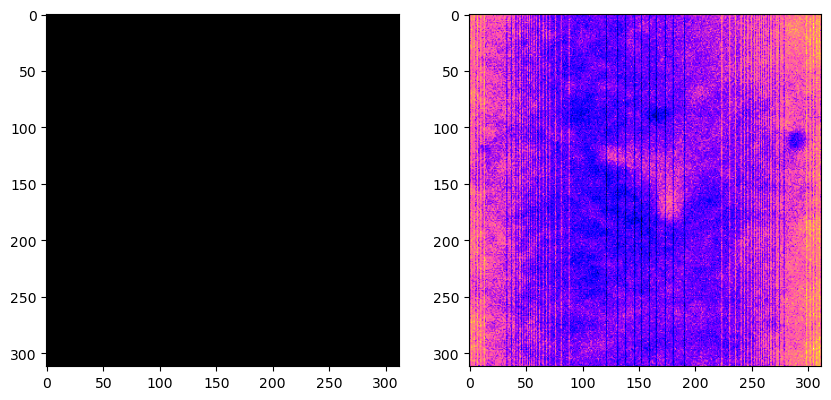

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(corr_image,cmap=plt.cm.gnuplot2)
plt.subplot(1,2,2)
plt.imshow(pnr_image,cmap=plt.cm.gnuplot2)

In [16]:
del input_movie